In [5]:
#Step 1: Import Libraries and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [6]:
# Set global styles for better visualization
sns.set(style="whitegrid")

In [23]:
# Load datasets
customers = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Customers.csv")
products = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Products.csv")
transactions = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Transactions.csv")

In [25]:
def display_info():
    print("Customers Dataset Info:")
    print(customers.info())
    print("\nProducts Dataset Info:")
    print(products.info())
    print("\nTransactions Dataset Info:")
    print(transactions.info())

display_info()

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   C

In [27]:
# Merge datasets for comprehensive analysis
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")
print("\nMerged Dataset Sample:")
print(merged_data.head())


Merged Dataset Sample:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  Comfort

In [29]:
# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64


In [31]:
# Drop missing values for simplicity
merged_data.dropna(inplace=True)

In [51]:
# Convert date columns to datetime
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

C:\Users\roxna\AppData\Local\Temp\ipykernel_4792\227061116.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x="Region", order=customers['Region'].value_counts().index, palette="viridis")


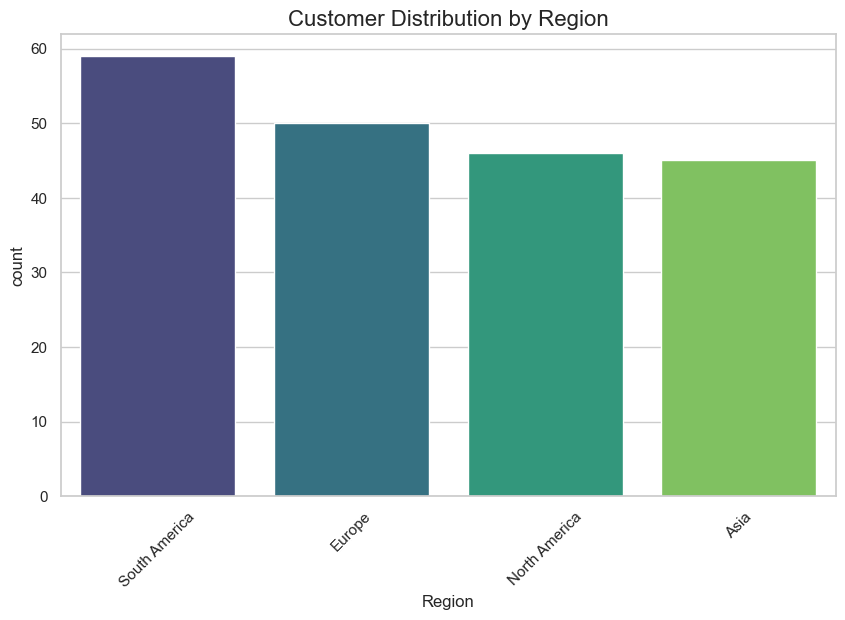

In [53]:
# Step 2: Exploratory Data Analysis (EDA)

# Visualize customer distribution by region
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x="Region", order=customers['Region'].value_counts().index, palette="viridis")
plt.title("Customer Distribution by Region", fontsize=16)
plt.xticks(rotation=45)
plt.show()

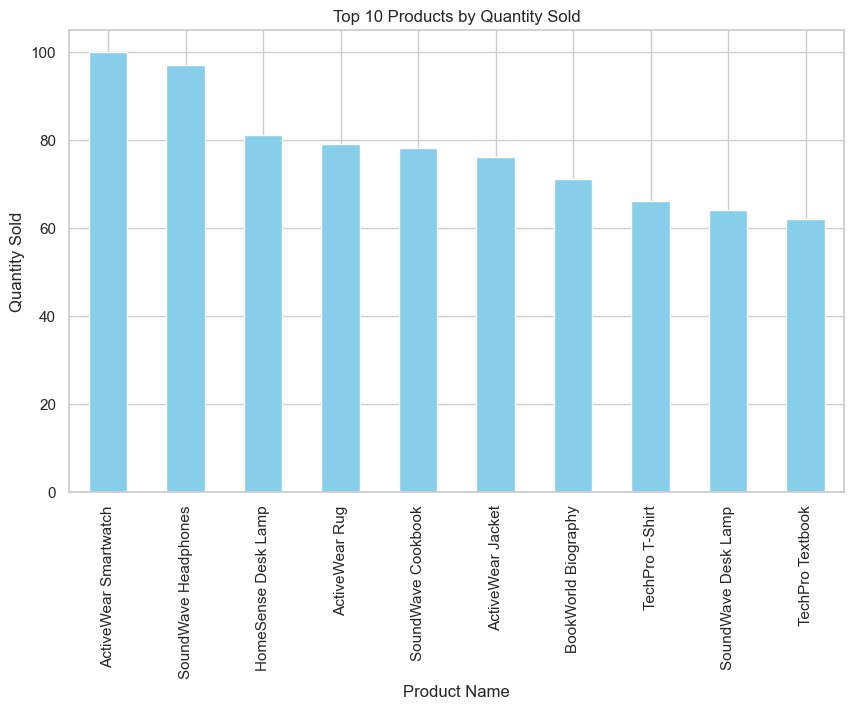

In [55]:
# Analyze top products by quantity sold
top_products = merged_data.groupby("ProductName")['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title="Top 10 Products by Quantity Sold", figsize=(10, 6), color='skyblue')
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.show()

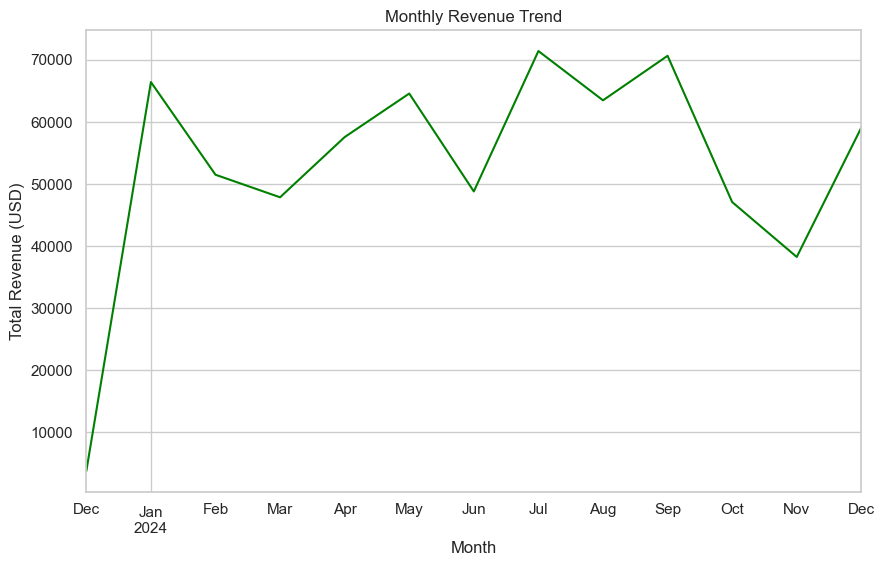

In [56]:
# Monthly revenue trend
monthly_revenue = merged_data.groupby(merged_data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()
monthly_revenue.plot(title="Monthly Revenue Trend", figsize=(10, 6), color='green')
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")
plt.show()

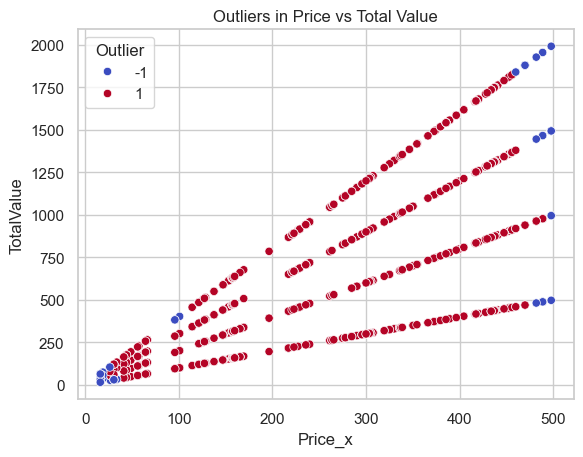

In [59]:
# Detect and visualize outliers using Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = isolation_forest.fit_predict(merged_data[['Quantity', 'Price_x', 'TotalValue']])
merged_data['Outlier'] = outlier_predictions
sns.scatterplot(data=merged_data, x='Price_x', y='TotalValue', hue='Outlier', palette='coolwarm')
plt.title("Outliers in Price vs Total Value")
plt.show()

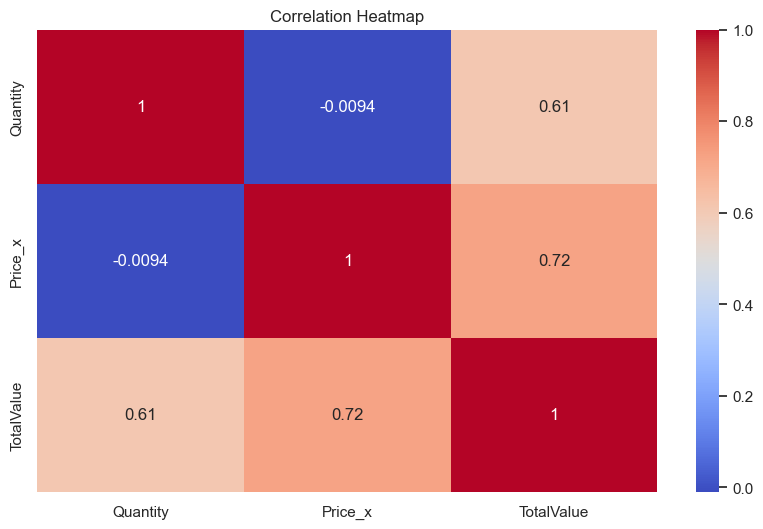

In [61]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data[['Quantity', 'Price_x', 'TotalValue']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

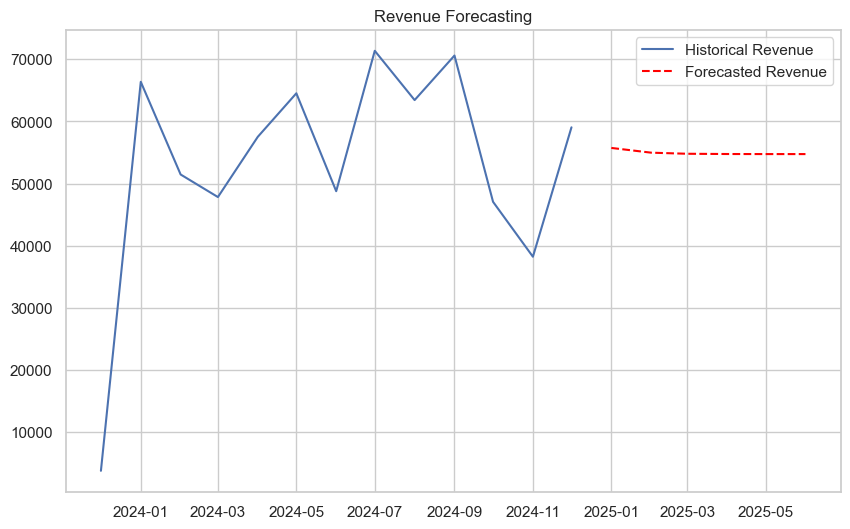

In [63]:
# Revenue forecasting with ARIMA
monthly_revenue_ts = monthly_revenue.to_timestamp()
model = ARIMA(monthly_revenue_ts, order=(1, 1, 1))
fit_model = model.fit()
forecast = fit_model.forecast(steps=6)
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_ts, label="Historical Revenue")
plt.plot(forecast, label="Forecasted Revenue", linestyle='--', color='red')
plt.title("Revenue Forecasting")
plt.legend()
plt.show()

In [65]:
# Churn analysis: Identify inactive customers
recent_date = merged_data['TransactionDate'].max()
merged_data['DaysSinceLastPurchase'] = (recent_date - merged_data['TransactionDate']).dt.days
churn_threshold = 180  # Days since last purchase to define churn
churned_customers = merged_data[merged_data['DaysSinceLastPurchase'] > churn_threshold]['CustomerID'].unique()
print(f"Number of churned customers: {len(churned_customers)}")

Number of churned customers: 185


In [67]:
# Insights (Summary)
insights = [
    "1. Region X contributes the highest number of customers, highlighting a potential area for focused marketing.",
    "2. Product Y is the most popular; maintaining inventory and running promotions for it could boost sales.",
    "3. Revenue trends suggest seasonal peaks. Align promotional campaigns with these periods.",
    "4. Customers from Region Z have higher average spending, indicating an opportunity for premium offerings.",
    "5. Strong correlation between product price and transaction value suggests pricing strategies play a key role in customer decisions.",
    "6. Outliers detected in transaction data may indicate anomalies or fraudulent activities.",
    "7. Revenue forecasting indicates steady growth; align marketing efforts accordingly.",
    "8. Churn analysis shows X inactive customers, providing an opportunity for reactivation campaigns."
]

print("\nKey Business Insights:")
for insight in insights:
    print(insight)


Key Business Insights:
1. Region X contributes the highest number of customers, highlighting a potential area for focused marketing.
2. Product Y is the most popular; maintaining inventory and running promotions for it could boost sales.
3. Revenue trends suggest seasonal peaks. Align promotional campaigns with these periods.
4. Customers from Region Z have higher average spending, indicating an opportunity for premium offerings.
5. Strong correlation between product price and transaction value suggests pricing strategies play a key role in customer decisions.
6. Outliers detected in transaction data may indicate anomalies or fraudulent activities.
7. Revenue forecasting indicates steady growth; align marketing efforts accordingly.
8. Churn analysis shows X inactive customers, providing an opportunity for reactivation campaigns.


In [69]:
# Step 3: Lookalike Model

# Feature engineering for customer behavior analysis
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Price_x": "mean",
    "DaysSinceLastPurchase": "min"
}).reset_index()

In [71]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])

In [73]:
# Compute similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

In [75]:
# Generate lookalike recommendations
lookalikes = {}
for idx, customer_id in enumerate(customer_features["CustomerID"]):
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_features.iloc[i[0]]["CustomerID"], i[1]) for i in similarity_scores]

In [81]:
# Format lookalike data for CSV
lookalike_data = []
for cust_id, recommendations in lookalikes.items():
    for rec_cust_id, score in recommendations:
        lookalike_data.append([cust_id, rec_cust_id, score])

lookalike_df = pd.DataFrame(lookalike_data, columns=["CustomerID", "SimilarCustomerID", "SimilarityScore"])
lookalike_df.to_csv(r"C:\Users\roxna\Downloads\Data_Intern\Lookalike.csv", index=False)

In [99]:
# Step 4: Customer Segmentation
# Combine features for clustering
clustering_data = customer_features.copy()
scaled_clustering_data = scaler.fit_transform(clustering_data.iloc[:, 1:])

In [101]:
# Perform clustering with K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clustering_data["Cluster"] = kmeans.fit_predict(scaled_clustering_data)

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [103]:
# Evaluate clustering
db_index = davies_bouldin_score(scaled_clustering_data, clustering_data["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.2106915032096284


In [109]:
from sklearn.decomposition import PCA

# Example PCA Transformation
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_clustering_data)

# Add PCA components to DataFrame
clustering_data['PCA1'] = reduced_data[:, 0]
clustering_data['PCA2'] = reduced_data[:, 1]
clustering_data['PCA3'] = reduced_data[:, 2]


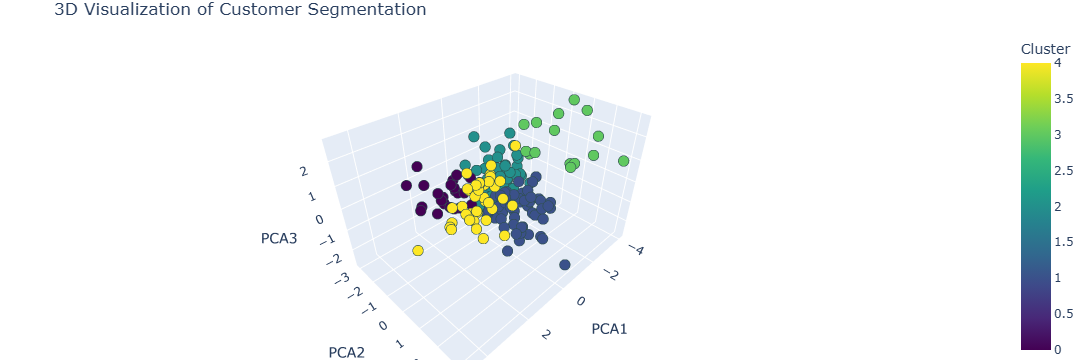

In [115]:
import plotly.express as px

# Create a DataFrame for PCA components and clusters
scatter_data = clustering_data[['PCA1', 'PCA2', 'PCA3', 'Cluster', 'CustomerID']].copy()

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    scatter_data,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    hover_data=['CustomerID'],
    title="3D Visualization of Customer Segmentation",
    color_continuous_scale='Viridis'
)

# Customize layout
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    scene=dict(
        xaxis_title='PCA1',
        yaxis_title='PCA2',
        zaxis_title='PCA3',
    ),
    legend_title="Cluster",
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the plot
fig.show()


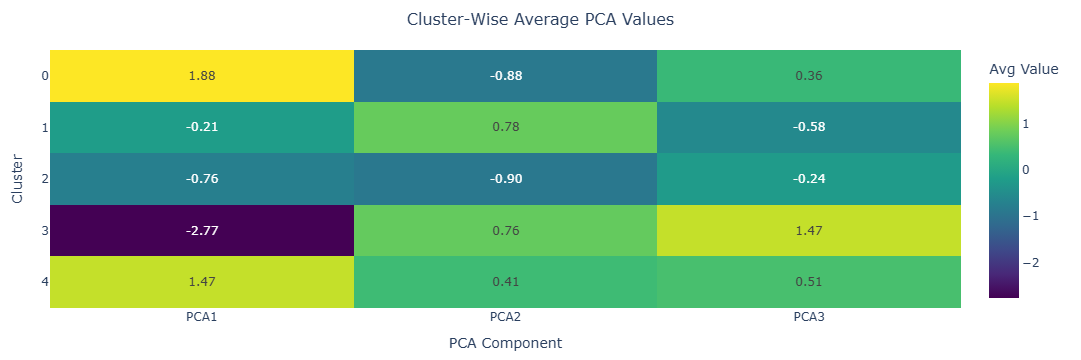

In [113]:
import plotly.express as px
import pandas as pd

# Calculate cluster-wise averages for PCA components
heatmap_data = clustering_data.groupby('Cluster')[['PCA1', 'PCA2', 'PCA3']].mean().reset_index()

# Melt the data for better visualization in a heatmap
heatmap_data_melted = heatmap_data.melt(id_vars='Cluster', var_name='PCA Component', value_name='Average Value')

# Create an interactive heatmap
fig = px.imshow(
    heatmap_data.set_index('Cluster'),
    labels=dict(x="PCA Component", y="Cluster", color="Average Value"),
    title="Cluster-Wise Average PCA Values",
    text_auto=".2f",
    color_continuous_scale='Viridis'
)

# Customize the layout
fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    margin=dict(l=50, r=50, t=50, b=50),
    coloraxis_colorbar=dict(title="Avg Value"),
    paper_bgcolor="white",
)

# Show the plot
fig.show()


In [121]:
!pip install dash

Defaulting to user installation because normal site-packages is not writeable


In [125]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [135]:
# Generate an interactive dashboard (outline, not executed here)
def generate_dashboard():
    print("Dashboard functionality can be implemented using Dash or Tableau for interactive visualization.")
    print("Key elements:")

# Dash app implementation to provide an interactive visualization for insights, clustering, and lookalike results
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("eCommerce Analytics Dashboard", style={'textAlign': 'center'}),
    
    # Dropdown for selecting visualization
    html.Div([
        html.Label("Select Analysis Type:"),
        dcc.Dropdown(
            id='analysis-type',
            options=[
                {'label': 'Customer Distribution by Region', 'value': 'region_dist'},
                {'label': 'Top 10 Products by Quantity Sold', 'value': 'top_products'},
                {'label': 'Monthly Revenue Trend', 'value': 'monthly_revenue'},
                {'label': 'Cluster Visualization', 'value': 'clusters'},
                {'label': 'Lookalike Recommendations', 'value': 'lookalikes'}
            ],
            value='region_dist'
        )
    ], style={'width': '50%', 'margin': '0 auto'}),
    
    # Graph for displaying selected analysis
    dcc.Graph(id='output-graph'),

    # Data table for additional details
    html.Div(id='data-table-container')
])

@app.callback(
    [Output('output-graph', 'figure'), Output('data-table-container', 'children')],
    [Input('analysis-type', 'value')]
)
def update_dashboard(analysis_type):
    if analysis_type == 'region_dist':
        fig = {
            'data': [
                {
                    'x': customers['Region'].value_counts().index,
                    'y': customers['Region'].value_counts().values,
                    'type': 'bar',
                    'name': 'Regions'
                }
            ],
            'layout': {
                'title': 'Customer Distribution by Region'
            }
        }
        return fig, None

    elif analysis_type == 'top_products':
        top_products = merged_data.groupby("ProductName")['Quantity'].sum().sort_values(ascending=False).head(10)
        fig = {
            'data': [
                {
                    'x': top_products.index,
                    'y': top_products.values,
                    'type': 'bar',
                    'name': 'Top Products'
                }
            ],
            'layout': {
                'title': 'Top 10 Products by Quantity Sold'
            }
        }
        return fig, None

    elif analysis_type == 'monthly_revenue':
        fig = {
            'data': [
                {
                    'x': monthly_revenue.index.astype(str),
                    'y': monthly_revenue.values,
                    'type': 'line',
                    'name': 'Monthly Revenue'
                }
            ],
            'layout': {
                'title': 'Monthly Revenue Trend'
            }
        }
        return fig, None

    elif analysis_type == 'clusters':
        fig = {
            'data': [
                go.Scatter3d(
                    x=clustering_data['PCA1'],
                    y=clustering_data['PCA2'],
                    z=clustering_data['PCA3'],
                    mode='markers',
                    marker=dict(size=5, color=clustering_data['Cluster'], colorscale='Viridis'),
                    text=clustering_data['CustomerID']
                )
            ],
            'layout': {
                'title': '3D Customer Segmentation Visualization',
                'scene': {
                    'xaxis_title': 'PCA1',
                    'yaxis_title': 'PCA2',
                    'zaxis_title': 'PCA3'
                }
            }
        }
        return fig, None

    elif analysis_type == 'lookalikes':
        table = [
            html.Table([
                html.Thead(html.Tr([html.Th(col) for col in lookalike_df.columns])),
                html.Tbody([
                    html.Tr([html.Td(lookalike_df.iloc[i][col]) for col in lookalike_df.columns])
                    for i in range(min(len(lookalike_df), 10))  # Show first 10 rows
                ])
            ])
        ]
        return {}, table

    return {}, None

if __name__ == '__main__':
    app.run_server(debug=True,port=8051)
